In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint

In [2]:
from sklearn.calibration import LabelEncoder
from common import get_full_data
def heart_failure():
    df = pd.read_csv("dataset/heart_failure_clinical_records_dataset.csv")
    # get dependent and independent features
    X=df.iloc[:,:-1]
    y=df.iloc[:,-1]
    classes = y.unique()
    X,y=get_full_data(X,y)
    return X,y,[str(c) for c in classes]

def encode_categorical_columns(df):
    le = LabelEncoder()
    # Loop over all columns in the DataFrame
    for col in df.columns:
        # Check if the column is of type object (string)
        if df[col].dtype == 'object':
            # Use LabelEncoder to do the numeric transformation
            df[col] = le.fit_transform(df[col])
    return df

def disease():
    df = pd.read_csv("dataset/disease.csv")
    # get dependent and independent features
    classes = df.iloc[:,0].unique()
    df = encode_categorical_columns(df)

    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    return X,y, classes

In [3]:
from xgboost import XGBRegressor,  XGBClassifier
X,y, y_classes = heart_failure()

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBClassifier(device='cpu')

In [4]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=200,
    cv=5,
    random_state=state,
    n_jobs=-1,
)

search_space_samples=4000

if search_space_samples>=len(X):
    search_space_samples=len(X)-2

_,X_search,_,y_search = train_test_split(X,y,test_size=search_space_samples/len(X),stratify=y)

search.fit(X_search,y_search)
special_model=search.best_estimator_

In [5]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.model_selection import RepeatedStratifiedKFold
from common import cross_val_classification_report

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X.to_numpy(),
    y=y,
    cv=cv,
    target_names=y_classes
)
print(report)

              precision    recall  f1-score   support

           1       0.84      0.94      0.89       609
           0       0.83      0.63      0.72       288

    accuracy                           0.84       897
   macro avg       0.84      0.78      0.80       897
weighted avg       0.84      0.84      0.83       897



Evaluate score  0.13072342445407473


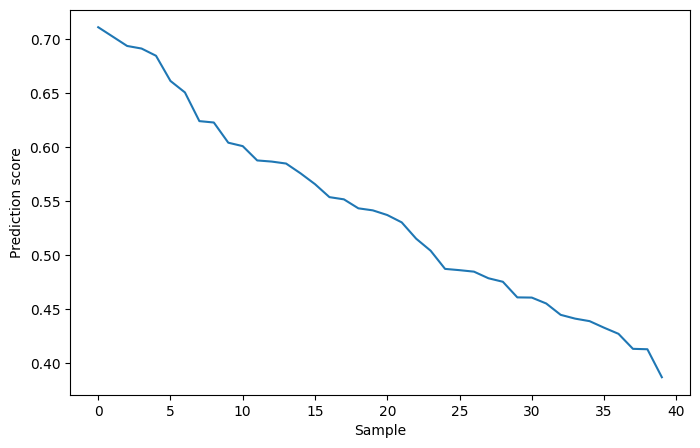

Evaluate score  0.0928761761592483


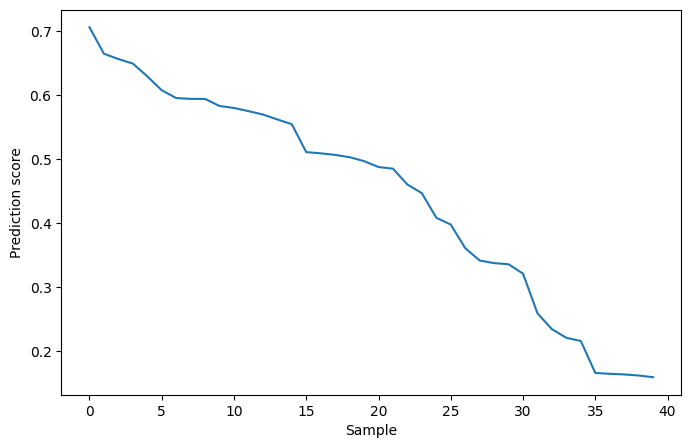

Evaluate score  0.07751022373391758


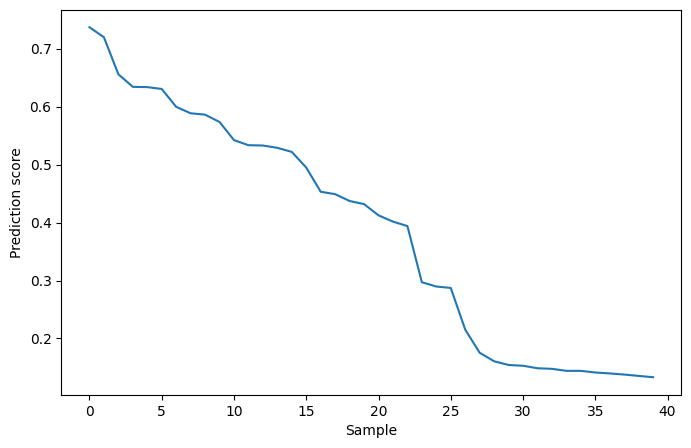

Evaluate score  0.06995849231660264


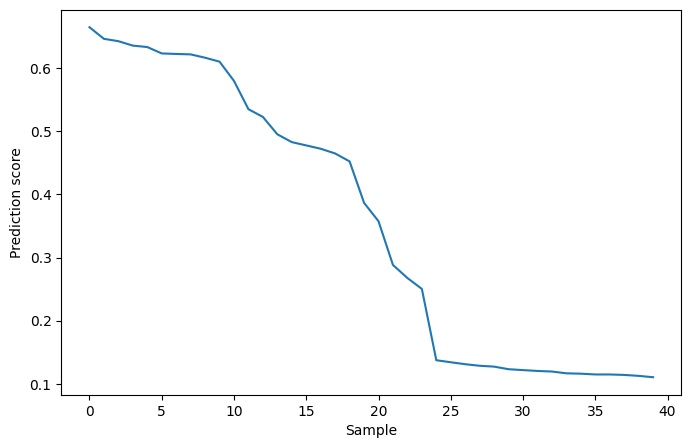

Evaluate score  0.069248471979629


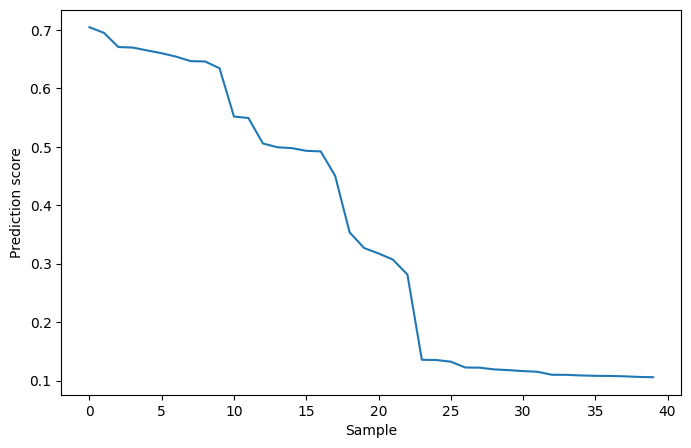

              precision    recall  f1-score   support

           1       0.94      0.95      0.95       600
           0       0.87      0.84      0.86       216

    accuracy                           0.93       816
   macro avg       0.91      0.90      0.90       816
weighted avg       0.92      0.93      0.92       816



In [7]:
# New method
from common import find_outliers

X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

outliers_mask, score = find_outliers(
    X_numpy,
    y_numpy,
    special_model,
    outliers_to_remove=0.1,
    iterations=5,
    gamma=0.5,
    evaluate_loss=metrics.mean_squared_error,
    repeats=5,
    cv=10,
    plot=True
)

X_clean = X_numpy[~outliers_mask]
y_clean = y_numpy[~outliers_mask]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X_clean,
    y=y_clean,
    cv=cv,
    target_names=y_classes
)
print(report)


Compare performance with some control model `SVC` with `rbf` kernel and standard scaler

Find optimal hyperparameters using `RandomSearchCV`